# Classification with K-Folding

In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import os


In [30]:
perm_df = pd.read_csv("perm_importance_mets.csv")
coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")
met_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/metabolite_clean.csv")

## coral_only
coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')
met_df_coral = met_df[met_df['refined_origin'] == 'Coral']

## all
coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')
met_df_all = met_df

y = coral_df['scleractinia']

/tmp/ipykernel_118712/723162809.py:2: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")



### feature sets (X) to test
coral_only: met_df_coral, perm_df['coralonly_rf'], and perm_df['coralonly_gb']  
all: met_df_all, perm_df['all_rfgb']  
for each feature set, do a StratifiedKFold with 5-folds and 80/20 train test so every row in the dataframe is held out test data once  
for each feature set, train a RandomForestClassifier and a XGBClassifier  
for each feature set and model architecture, record the prediction accuracy and confusion matrix for the overall model across all folds  
for each feature set, record any missed classifications by returning the entire row in the original coral_df (this has information   about metadata like species and location)

In [31]:

coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')
y = coral_df['scleractinia']

# metabolites to use
coral_origin_mets = [m for m in met_df[met_df['refined_origin'] == 'Coral']['metabolite'].unique() if m in coral_df.columns]
all_origin_mets = [m for m in met_df['metabolite'].unique() if m in coral_df.columns]

# all feature scenarios to test
scenarios = {
    "coral_only_pruned_rf": [m for m in perm_df['coralonly_rf'].dropna() if m in coral_origin_mets],
    "coral_only_pruned_gb": [m for m in perm_df['coralonly_gb'].dropna() if m in coral_origin_mets],
    "coral_only_FULL": coral_origin_mets,
    "all_pruned_rfgb": [m for m in perm_df['all_rfgb'].dropna() if m in all_origin_mets],
    "all_FULL": all_origin_mets
}

models_to_run = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=123),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
final_metrics = []
all_missed_dfs = []

for s_name, feat_list in scenarios.items():    
    X = coral_df[feat_list].fillna(0)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    for m_name, model in models_to_run.items():
        run_id = f"{s_name}_{m_name}"
        print(f"Running: {run_id} with ({len(feat_list)} features)")
        
        y_pred = cross_val_predict(model, X, y, cv=skf)
        
        # record performance
        acc = accuracy_score(y, y_pred)
        final_metrics.append({'run': run_id, 'accuracy': acc})
        
        # record missed classifications
        missed_mask = (y != y_pred)
        if missed_mask.any():
            missed_df = coral_df[missed_mask].copy()
            missed_df['missed_on_run'] = run_id
            missed_df['predicted_label'] = y_pred[missed_mask]
            all_missed_dfs.append(missed_df)

# combine all missed rows into one  dataframe
master_missed_df = pd.concat(all_missed_dfs, ignore_index=True)

summary_df = pd.DataFrame(final_metrics)
summary_df

Running: coral_only_pruned_rf_RandomForest with (54 features)
Running: coral_only_pruned_rf_XGBoost with (54 features)


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:56:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Running: coral_only_pruned_gb_RandomForest with (67 features)
Running: coral_only_pruned_gb_XGBoost with (67 features)


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:56:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Running: coral_only_FULL_RandomForest with (3623 features)
Running: coral_only_FULL_XGBoost with (3623 features)


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:56:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:56:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Running: all_pruned_rfgb_RandomForest with (51 features)
Running: all_pruned_rfgb_XGBoost with (51 features)


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Running: all_FULL_RandomForest with (16368 features)
Running: all_FULL_XGBoost with (16368 features)


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

,run,accuracy
0,coral_only_pruned_rf_RandomForest,0.994718
1,coral_only_pruned_rf_XGBoost,0.989437
2,coral_only_pruned_gb_RandomForest,0.994718
3,coral_only_pruned_gb_XGBoost,0.991197
4,coral_only_FULL_RandomForest,1.000000
5,coral_only_FULL_XGBoost,0.998239
6,all_pruned_rfgb_RandomForest,0.991197
7,all_pruned_rfgb_XGBoost,0.996479
8,all_FULL_RandomForest,0.998239
9,all_FULL_XGBoost,0.998239


Running: coral_only_pruned_rf_RandomForest...
Running: coral_only_pruned_rf_XGBoost...


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Running: coral_only_pruned_gb_RandomForest...
Running: coral_only_pruned_gb_XGBoost...


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Running: coral_only_FULL_RandomForest...
Running: coral_only_FULL_XGBoost...


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Running: all_pruned_rfgb_RandomForest...
Running: all_pruned_rfgb_XGBoost...


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Running: all_FULL_RandomForest...
Running: all_FULL_XGBoost...


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:57:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:58:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:58:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:58:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

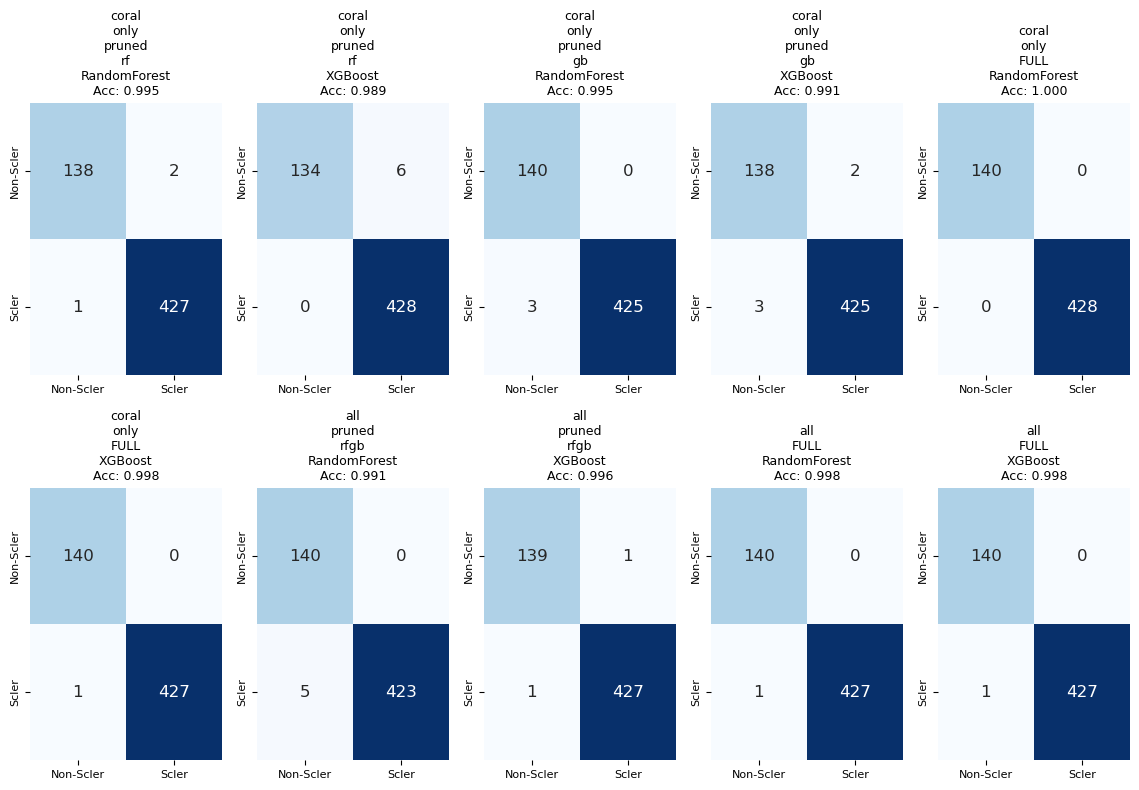

saved fig to: /work/hs325/World_Corals/misc/figs/cmatrices.jpg


In [32]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

n_total_runs = len(scenarios) * len(models_to_run)
# Set figure for slide dimensions 
fig, axes = plt.subplots(2, 5, figsize=(11.5, 8)) 
axes = axes.flatten()
plot_idx = 0

final_metrics = []
all_missed_dfs = []

for s_name, feat_list in scenarios.items():    
    X = coral_df[feat_list].fillna(0)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    for m_name, model in models_to_run.items():
        run_id = f"{s_name}_{m_name}"
        print(f"Running: {run_id}...")
        
        y_pred = cross_val_predict(model, X, y, cv=skf)
        
        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        final_metrics.append({'run': run_id, 'accuracy': acc})
        
        missed_mask = (y != y_pred)
        if missed_mask.any():
            missed_df = coral_df[missed_mask].copy()
            missed_df['missed_on_run'] = run_id
            missed_df['predicted_label'] = y_pred[missed_mask]
            all_missed_dfs.append(missed_df)

        ax = axes[plot_idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, annot_kws={"size": 12})
        
        display_title = run_id.replace('_', '\n')
        ax.set_title(f"{display_title}\nAcc: {acc:.3f}", fontsize=9)
        ax.set_xticklabels(['Non-Scler', 'Scler'], fontsize=8)
        ax.set_yticklabels(['Non-Scler', 'Scler'], fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        
        plot_idx += 1

# Delete any unused subplots if runs < 10
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
save_path = "/work/hs325/World_Corals/misc/figs/cmatrices.jpg"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"saved fig to: {save_path}")
master_missed_df = pd.concat(all_missed_dfs, ignore_index=True)

In [33]:
master_missed_df[['host_phylum', 'host_order', 'host_genus', 'host_species', 'missed_on_run', 'predicted_label']]

,host_phylum,host_order,host_genus,host_species,missed_on_run,predicted_label
0,Cnidaria,Scleractinia,Oculina,varicosa,coral_only_pruned_rf_RandomForest,0
1,Cnidaria,Corallimorpharia,NaN,NaN,coral_only_pruned_rf_RandomForest,1
2,Cnidaria,Zoantharia,Parazoanthus,swiftii,coral_only_pruned_rf_RandomForest,1
3,Porifera,Poecilosclerida,Desmapsamma,anchorata,coral_only_pruned_rf_XGBoost,1
4,Porifera,Haplosclerida,Niphates,erecta,coral_only_pruned_rf_XGBoost,1
5,Porifera,Poecilosclerida,Monanchora,barbadensis,coral_only_pruned_rf_XGBoost,1
6,Cnidaria,Actiniaria,Condylactis,gigantea,coral_only_pruned_rf_XGBoost,1
7,Cnidaria,Antipatharia,NaN,NaN,coral_only_pruned_rf_XGBoost,1
8,Rhodophyta,Corallinales,NaN,NaN,coral_only_pruned_rf_XGBoost,1
9,Cnidaria,Scleractinia,Oculina,varicosa,coral_only_pruned_gb_RandomForest,0


# Permutation importance

In [36]:
## compute permutation importance on each feature set now for the reduced feature sets
## assume the coraldf, metdf, permdf are already defined and packages already loaded

coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')
y = coral_df['scleractinia']

# metabolites to use
coral_origin_mets = [m for m in met_df[met_df['refined_origin'] == 'Coral']['metabolite'].unique() if m in coral_df.columns]
all_origin_mets = [m for m in met_df['metabolite'].unique() if m in coral_df.columns]

# all feature scenarios to test
scenarios = {
    "coral_only_pruned_rf": [m for m in perm_df['coralonly_rf'].dropna() if m in coral_origin_mets],
    "coral_only_pruned_gb": [m for m in perm_df['coralonly_gb'].dropna() if m in coral_origin_mets],
    "all_pruned_rfgb": [m for m in perm_df['all_rfgb'].dropna() if m in all_origin_mets],
}

models_to_run = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=123),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
}


Computing Permutation Importance for: coral_only_pruned_rf_RandomForest
Computing Permutation Importance for: coral_only_pruned_rf_XGBoost


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:09:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Computing Permutation Importance for: coral_only_pruned_gb_RandomForest
Computing Permutation Importance for: coral_only_pruned_gb_XGBoost


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:09:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Computing Permutation Importance for: all_pruned_rfgb_RandomForest
Computing Permutation Importance for: all_pruned_rfgb_XGBoost


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:09:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


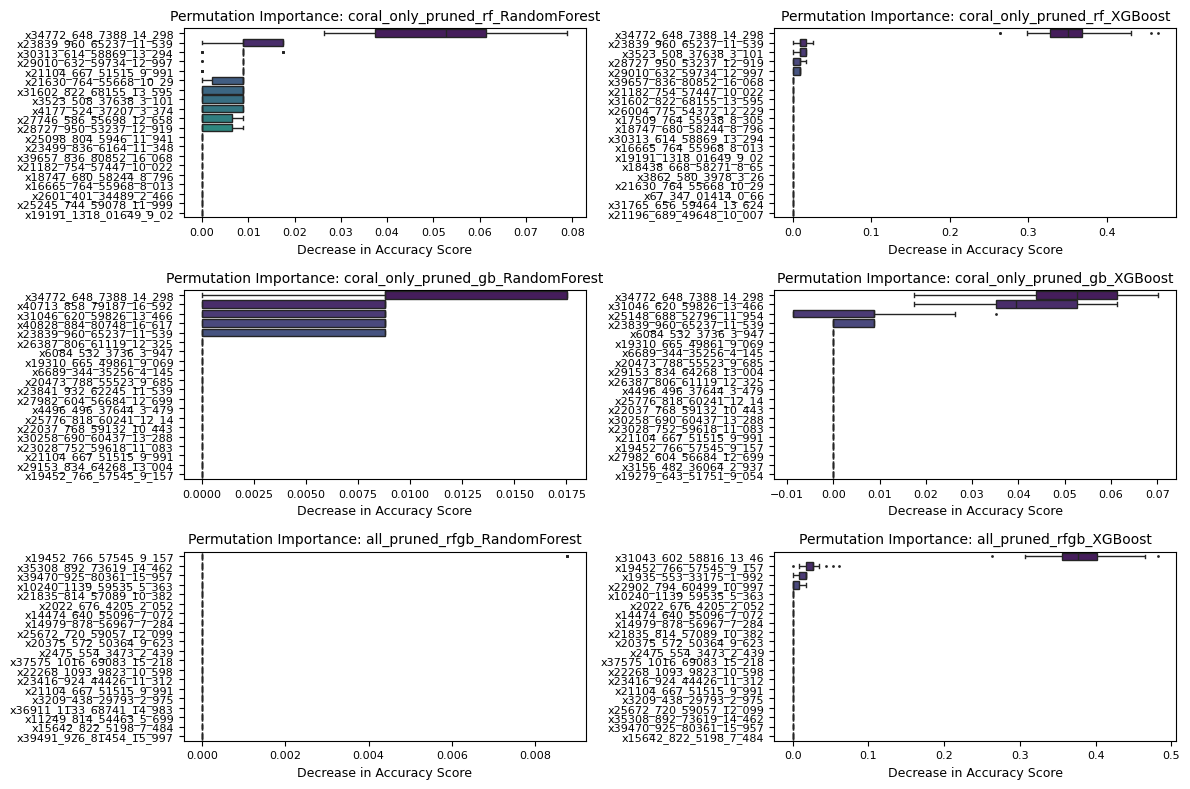

In [40]:
importance_results = {}

# Set up the plotting grid (3 scenarios x 2 models = 6 plots)
fig, axes = plt.subplots(len(scenarios), len(models_to_run), figsize=(12, 8))
axes = axes.flatten()
plot_idx = 0

for s_name, feat_list in scenarios.items():
    X = coral_df[feat_list].fillna(0)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=123
    )
    
    for m_name, model in models_to_run.items():
        run_id = f"{s_name}_{m_name}"
        print(f"Computing Permutation Importance for: {run_id}")
        
        # fit Mmdel and compute perm importance
        model.fit(X_train, y_train)
        r = permutation_importance(model, X_test, y_test,
                                   n_repeats=30,
                                   random_state=123,
                                   n_jobs=-1)
        
        sorted_idx = r.importances_mean.argsort()[::-1] # Sort descending
        top_indices = sorted_idx[:20] # Show top 20 for clarity if list is long
        # top_indices = sorted_idx

        importances_df = pd.DataFrame(
            r.importances[top_indices].T,
            columns=np.array(feat_list)[top_indices]
        )
        
        # plot
        ax = axes[plot_idx]
        sns.boxplot(data=importances_df, orient='h', ax=ax, palette="viridis", fliersize=1)
        ax.set_title(f"Permutation Importance: {run_id}", fontsize=10)
        ax.set_xlabel("Decrease in Accuracy Score", fontsize=9)
        ax.tick_params(labelsize=8)
        
        plot_idx += 1

plt.tight_layout()
imp_save_path = "/work/hs325/World_Corals/misc/figs/permutation_importance_reduced.jpg"
os.makedirs(os.path.dirname(imp_save_path), exist_ok=True)
plt.savefig(imp_save_path, dpi=300, bbox_inches='tight')
plt.show()